<a id="top"></a>
# Exploring UV extinction curves – Part 2
***

This is the continuation of _Exploring UV extinction curves – Part 1_. Said tutorial explores how to access the International Ultraviolet Explorer (IUE) through the MAST database, download specific data and process it. In this tutorial all those steps will not be explained, since they are not the goal, but for more detail about said part the user is encouraged to refer to the first part of this tutorial. 

_**Can we reference the other tutorial with a link somehow? Maybe when they are already available in the repository?**_

## Learning goals

By the end of this tutorial, you will be able to:

- Understand what a UV extinction curve is and how it is used to study dust properties
- Create your own UV extinction curve and plot it
- Parametrize a curve based on your UV extinction curve
- Implement Python functions
- Discover the difference in the trend for curves corresponding to the Small and Large Magellanic Clouds (LMC and SMC)

## Introduction

**Extinction curve background**: An extinction curve represents the wavelength dependence of dust extinction. It compares the inherent Spectral Energy Distribution (SED) (~dust-free) of a star to the observed SED affected by dust extinction. Normally these curves are created by representing $k(\lambda-V)$ versus $1/\lambda$, with $\lambda$ being the wavelength.

Extinction is relevant in many different scenarios. Dust can be found very near the observed object – such as stars having disks or proto-stellar clouds surrounding it – or can be far away from it but still affect the observation performed – for example dust in a galaxy that happens to be between the observer and the star.

**Defining some terms**:

- **Color index**: difference between magnitude of a star in 2 different passbands, typically B and V. Symbol: $(B-V)$. 
- **Extinction**: measure of interstellar reddening quantified by the difference in magnitudes. Symbol: $A_\lambda$.
- **Spectral type**: stellar classification from hotter (O stars) to cooler (M stars). Temperature defines a star's "color" and surface brightness.


**Useful equations**
- $k(\lambda-V) = \frac{E(\lambda-V)}{E(B-V)} = \frac{m(\lambda-V)-m(\lambda-V)_o}{(B-V)-(B-V)_o} = \frac{A(\lambda)-A(V)}{A(B)-A(V)}$

    **Note**: the $x_o$ terms refer to the star that is nearly unaffected by dust, i.e. $(B-V)$ corresponds to the observed color index and $(B-V)_o$ to the observed color index if there was no extinction due to dust. The stars should have the same spectral type in order to perform this comparison. 
    
## Table of Contents 
* [Imports](#Imports)
* [Data loading](#Data-loading)
* [Data plotting](#Data-plotting)
* [Extinction curve construction](#Extinction-curve-construction)
* [Curve parametrization](#Curve-parametrization)
* [Exercises](#Exercises)
* [Additional Resources](#Additional-Resources)

## Imports

The first step will be to import the libraries we will be using throughout this tutorial: 

- `matplotlib.pyplot` for plotting data
- `numpy` for array manipulations
- `Simbad` from _astroquery.simbad_ to query the SIMBAD astronomical database.
- `curve_fit` from scipy.optimize for data-fitting

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astroquery.simbad import Simbad
from scipy.optimize import curve_fit

_**Warning**: If you have not installed the astroquery package in your computer, you may need to. Information about astroquery can be found <a href="https://astroquery.readthedocs.io/en/latest/">here</a>._

## Data loading

In order to follow the steps presented here, you should have completed _Exploring UV extinction curves – Part 1_ since we will use .txt files that were created in that tutorial.

To create an extinction curve, we need a reddened and an unreddened star. Let's load the data for the corresponding stars' fluxes and corresponding wavelengths.

_**Note**: to load the .txt files they should be stored in the same directory as this notebook, if you have saved the files somewhere else copy them now into the current directory in which you are working now._

In [2]:
wav_av214_sw = np.loadtxt('wav_av214_sw.txt')
flux_av214_sw = np.loadtxt('flux_av214_sw.txt')

wav_av214_lw = np.loadtxt('wav_av214_lw.txt')
flux_av214_lw = np.loadtxt('flux_av214_lw.txt')

wav_av380_sw = np.loadtxt('wav_av380_sw.txt')
flux_av380_sw = np.loadtxt('flux_av380_sw.txt')

wav_av380_lw = np.loadtxt('wav_av380_lw.txt')
flux_av380_lw = np.loadtxt('flux_av380_lw.txt')

## Data plotting

Let's now plot the logarithm of their flux versus the inverse of the wavelength, as it is normally done in this type of studies.

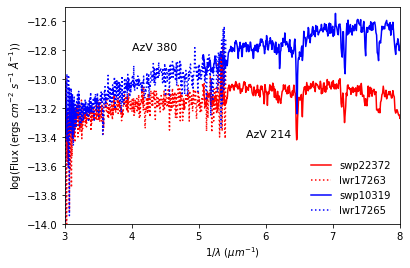

In [3]:
wavinv_av214_sw = 1/(wav_av214_sw*1e-4) # mu-m ^-1
wavinv_av214_lw = 1/(wav_av214_lw*1e-4) # mu-m ^-1
wavinv_av380_sw = 1/(wav_av380_sw*1e-4) # mu-m ^-1
wavinv_av380_lw = 1/(wav_av380_lw*1e-4) # mu-m ^-1

fig = plt.figure()
ax = plt.subplot(111)

plt.plot(wavinv_av214_sw,np.log10(flux_av214_sw),'r',label='swp22372')
plt.plot(wavinv_av214_lw,np.log10(flux_av214_lw),'r:',label='lwr17263')
plt.text(4, -12.8,'AzV 380', fontsize = 11)
plt.plot(wavinv_av380_sw,np.log10(flux_av380_sw),'b',label='swp10319')
plt.plot(wavinv_av380_lw,np.log10(flux_av380_lw),'b:',label='lwr17265')
plt.text(5.7, -13.4, 'AzV 214', fontsize = 11)

ax.set_xlabel('1/$\lambda$ ($\mu m^{-1}$)')
ax.set_ylabel(r'log(Flux (ergs $cm^{-2}$ $s^{-1}$ $\AA^{-1}$))')
ax.set_xlim([3, 8])
ax.set_ylim([-14, -12.5])

plt.legend(loc='best',frameon=False)

plt.show()

## Extinction curve construction

Let's now use <a href="http://simbad.cds.unistra.fr/simbad/">SIMBAD</a> database to look for the fluxes in the B and V bands for both stars. We can do a simple query using the identifier of both stars. The magnitudes can be found under the 8th subgroup presented below the name of the stars, called 'Fluxes', since SIMBAD can provide you with either the flux or the magnitude of the star in those bands.

- AzV 214: $m_V = 13.39$, $m_B = 13.40$.
- AzV 380: $m_V = 13.53$, $m_B = 13.43$.

From these values we can directly calculate the value of $E(B-V) = (B-V)-(B-V)_o$. In order to do this using Python we can do the following, first add the fields for the query that we want, namely _flux(B)_ and _flux(V)_, and then look for the specific target we are interested in:

In [4]:
Simbad.add_votable_fields('flux(B)','flux(V)')
table_av214 = Simbad.query_object('AzV 214')
table_av214

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,FLUX_B,FLUX_V,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,mag,mag,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,float32,float32,int32
AzV 214,00 58 54.7802,-72 13 17.172,14,14,0.014,0.012,90,A,O,2020yCat.1350....0G,13.4,13.39,1


In [5]:
table_av380 = Simbad.query_object('AzV 380')
table_av380

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,FLUX_B,FLUX_V,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,mag,mag,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,float32,float32,int32
SK 120,01 05 24.7610,-73 03 52.973,14,14,0.019,0.019,90,A,O,2020yCat.1350....0G,13.43,13.53,1


In [6]:
V_214 = float(table_av214['FLUX_V'])
B_214 = float(table_av214['FLUX_B'])

V_380 = float(table_av380['FLUX_V'])
B_380 = float(table_av380['FLUX_B'])

E_B_V = (B_214-V_214)-(B_380-V_380)

print("The value of E(B-V) is equal to",E_B_V)

The value of E(B-V) is equal to 0.10999870300292969


So finally, let's plot the extinction curve!

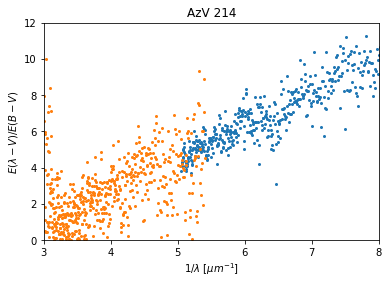

In [7]:
plt.figure()
plt.plot(wavinv_av214_sw,np.abs((np.log(flux_av214_sw/flux_av380_sw)-np.log(V_214/V_380))/E_B_V),'o',markersize=2)
plt.plot(wavinv_av214_lw,np.abs((np.log(flux_av214_lw/flux_av380_lw)-np.log(V_214/V_380))/E_B_V),'o',markersize=2)
plt.xlim([3,8])
plt.ylim([0,12])
plt.xlabel(r'$1/\lambda$ $[\mu m^{-1}]$')
plt.ylabel(r'$E(\lambda-V)/E(B-V)$')
plt.title('AzV 214')
plt.show()

This is the typical shape encountered for extinction curves corresponding to the Small Magellanic Cloud (SMC), as can be seen in <a href="https://arxiv.org/pdf/astro-ph/0305257.pdf">Smith et al. 2020</a>.

## Curve parametrization

Now that we have the curve, we can parametrize it! First let's combine the arrays we have into one unique 1D vector:

In [8]:
wvinv = np.concatenate((wavinv_av214_lw,wavinv_av214_sw))
k_lam_V = np.concatenate((np.abs((np.log(flux_av214_lw/flux_av380_lw)-np.log(V_214/V_380))/E_B_V),np.abs((np.log(flux_av214_sw/flux_av380_sw)-np.log(V_214/V_380))/E_B_V)))

Let's create the x-vector that we will use for the data-fitting, _$x = 1/\lambda$_, using `np.linspace`:

In [9]:
n = 1000
x_wavinv = np.linspace(3,8,n)

Now, let's parametrize the curve according to the FM parametrization as presented in
<a href="https://ui.adsabs.harvard.edu/abs/1990ApJS...72..163F/abstract">Fitzpatrick and Massa 1990</a>. Fist, let's create the function with the suggested structure of the article. A function in Python is defined starting with the word def, then the name of your function, inside the parenthesis the inputs are defined, and the output of said function is whatever follows the word _return_. More information on Python functions can be found <a href="https://www.datacamp.com/tutorial/functions-python-tutorial">here</a>.

In [10]:
def FMpar(x, C1, C2, C3, C4, xo, gamma):
    
    """
    Parametrization of UV extinction curve according to Fitzpatrick and Massa 1990
    
    Inputs:
    :param x: input inverse-wavelength arrays (x = 1/wavelength)
    :type x: float array
    :param C1, C2, C3, C4, xo, gamma: input parameters to be fitted
    :type C1, C2, C3, C4, xo, gamma: float
    
    Outputs: 
    :return: k, extinction curve evaluated for the different x's
    :rtype: float array
    """

    F = np.zeros(len(x))
    for i in range(len(x)):
        if x[i] >= 5.9:
            F = 0.5392*(x-5.9)**2+0.05644*(x-5.9)**3
        
    D = x**2/((x**2-xo**2)**2+x**2*gamma**2)
    
    k = C1 + C2*x + C3*D + C4*F
    
    return k

Some initial conditions can be found in <a href="https://ui.adsabs.harvard.edu/abs/2003ApJ...594..279G/abstract">Smith et al. 2022</a> for the parametrization, especially regarding $x_o$ and $\gamma$, and will be used here to look for the best fit.

In [11]:
ic = np.array([1.0,1.0,1.0,1.0,4.6,1.0])

parameters, covariance = curve_fit(FMpar, wvinv, k_lam_V, p0 = ic)

print('Parameters obtained for fit: \n')
print('C1: ',parameters[0])
print('C2: ',parameters[1])
print('C3: ',parameters[2])
print('C4: ',parameters[3])
print('xo: ',parameters[4])
print('gamma: ',parameters[5])

Parameters obtained for fit: 

C1:  40.628042048171835
C2:  -2.7117742538132172
C3:  -809.9061826832635
C4:  0.6554932825718807
xo:  3.0898891742886936
gamma:  -5.0738755237565405


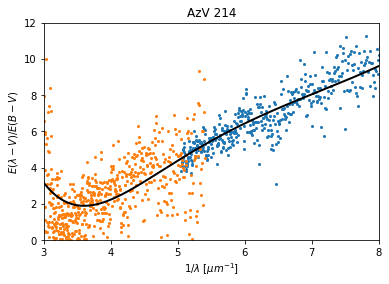

In [12]:
F = 0.5392*(x_wavinv-5.9)**2+0.05644*(x_wavinv-5.9)**3
D = x_wavinv**2/((x_wavinv**2-parameters[4]**2)**2+x_wavinv**2*parameters[5]**2)
k = parameters[0] + parameters[1]*x_wavinv + parameters[2]*D + parameters[3]*F

plt.figure()
plt.plot(wavinv_av214_sw,np.abs((np.log(flux_av214_sw/flux_av380_sw)-np.log(V_214/V_380))/E_B_V),'o',markersize=2)
plt.plot(wavinv_av214_lw,np.abs((np.log(flux_av214_lw/flux_av380_lw)-np.log(V_214/V_380))/E_B_V),'o',markersize=2)
plt.plot(x_wavinv,k,'k',linewidth=2)
plt.xlim([3,8])
plt.ylim([0,12])
plt.xlabel(r'$1/\lambda$ $[\mu m^{-1}]$')
plt.ylabel(r'$E(\lambda-V)/E(B-V)$')
plt.title('AzV 214')
plt.show()

_**Note**: the bump that can be appreciated at low values for the x-axis ($1/\lambda \sim 3$) is due to the scattering of the points, not to the real trend of the curve, which additionally affects the parametrization values obtained. Extinction curves should start at $(1/\lambda, E(\lambda-V)/E(B-V)) = (0, 0)$ theoretically._

## Exercises

Now you can try to do it yourself! Try to obtain the extinction curve of a Large Magellanic Cloud (LMC) following the steps presented for the SMC one and look for the differences in the trend between the two.

### 1. Load the data

The targets for this exercise will be:

- Sk -69 206 (reddened star) - wav_sk_69_206_sw.txt, flux_sk_69_206_sw.txt, wav_sk_69_206_lw.txt, flux_sk_69_206_lw.txt
- Sk -67 5 (unreddened star) - wav_sk_67_5_sw.txt, flux_sk_67_5_sw.txt, wav_sk_67_5_lw.txt, flux_sk_67_5_lw.txt

In [13]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before


### 2. Plot the spectra of both stars

Remember that normally in these studies you plot the logarithm of the fluxes versus the inverse of the wavelengths.

In [14]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before


### 3. Find the values for the B and V bands in SIMBAD

For the reddened star:

In [15]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before


For the unreddened star:

In [16]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before


Now, calculate the $E(B-V)$ value: 

In [17]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before


### 4. Create the scattered extinction curve

In [18]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before


### 5. Parametrize the curve

First, obtain the parameters for the curve fitting:

In [19]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before


Once you have that, include the fit in the extinction curve you obtained:

In [20]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
# You can also use any function that was defined before


Can you see the difference in the trend followed by the extinction curve between this case (LMC) and the one before (SMC)? More information about the different trends can be found in <a href="https://arxiv.org/pdf/astro-ph/0305257.pdf">Gordon et al. 2003</a>.

## Additional Resources

For more information about the MAST archive and details about mission data: 

* <a href="https://mast.stsci.edu/api/v0/index.html">MAST API</a> <br>
* <a href="https://archive.stsci.edu/iue/">International Ultraviolet Explorer Page (MAST)</a> <br>
* <a href="https://archive.stsci.edu/iue/mdr_help.html">IUE Data Retrieval Help Page</a> 

For more information about extinction curves and their parametrization:


* <a href="https://ui.adsabs.harvard.edu/abs/2003ApJ...594..279G/abstract">A quantitative comparison of SMC, LMC and Milky Way UV to NIR extinction curves</a> <br>
* <a href="https://adsabs.harvard.edu/pdf/1990ApJS...72..163F">An analysis of the shapes of the ultraviolet extinction curves. III. An atlas of ultraviolet extinction curves</a> 

## About this Notebook

**Author**: Clara Puerto Sánchez <br>
**Keyword(s)**: Tutorial, UV, reddening, extinction-curve <br>
**Last Updated**: Aug 2022 <br>
**Next review**: Mar 2023

For support, please contact the Archive HelpDesk at archive@stsci.edu.
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>